<a href="https://colab.research.google.com/github/amiralitah/LSTM-Sequence-Completion/blob/main/Deep_Learning_Mastering_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Number of English sentences: 141543
tom dropped his flashlight 
dropped his flashlight <EOS>
tom has been driving us crazy 
has been driving us crazy <EOS>
she agreed with him 
agreed with him <EOS>
i just found out that tom is mary's ex boyfriend 
just found out that tom is mary's ex boyfriend <EOS>
tom watches mary 
watches mary <EOS>
faith is believing what you know ain't true 
is believing what you know ain't true <EOS>
dataset_sizes = {'train': 1000, 'val': 1000, 'test': 1000}

Epoch 1/44
----------
train Loss: 6.0292
val Loss: 5.7845
test Loss: 5.7651

Epoch 2/44
----------
train Loss: 5.0768
val Loss: 5.9482
test Loss: 5.9203

Epoch 3/44
----------
train Loss: 4.6671
val Loss: 6.2801
test Loss: 6.2442

Epoch 4/44
----------
train Loss: 4.2484
val Loss: 6.6554
test Loss: 6.6067

Epoch 5/44
----------
train Loss: 3.7908
val Loss: 6.8174
test Loss: 6.7571

Epoch 6/44
----------
train Loss: 3.3665
val Loss: 7.2426
test Loss: 7.1714

Epoch 7/44
----------
train Loss: 2.9463
val Loss:

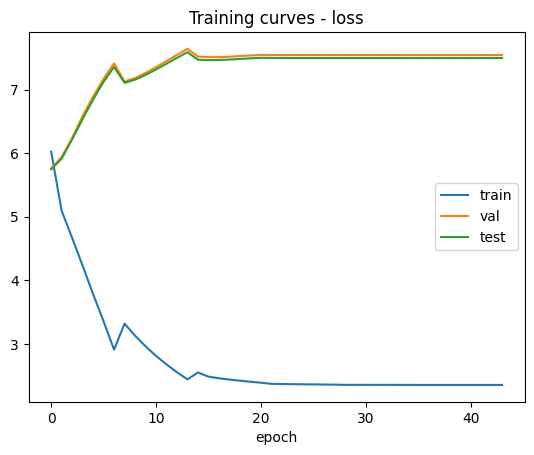

In [6]:
import unicodedata
import string
import random
import re

import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
import time, copy
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Helper functions

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r"", s)
    s = re.sub(r"[^a-zA-Z.!'?]+", r" ", s)
    return s

def parse_data(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    pairs = [[pair[0], pair[1]] for pair in pairs]
    return pairs

# Parse the data
pairs = parse_data("spa.txt")
english_sentences = [pair[0] for pair in pairs]
random.shuffle(english_sentences)
print("Number of English sentences:", len(english_sentences))

# Split the data
train_sentences = english_sentences[:1000]
val_sentences = english_sentences[1000:2000]
test_sentences = english_sentences[2000:3000]

# Create the word dictionary
def add_words_to_dict(word_dictionary, word_list, sentences):
    for sentence in sentences:
        for word in sentence.split(" "):
            if word in word_dictionary:
                continue
            else:
                word_list.append(word)
                word_dictionary[word] = len(word_list)-1

english_dictionary = {}
english_list = []
add_words_to_dict(english_dictionary, english_list, train_sentences)
add_words_to_dict(english_dictionary, english_list, val_sentences)
add_words_to_dict(english_dictionary, english_list, test_sentences)

# Create tensors
def create_input_tensor(sentence, word_dictionary):
    words = sentence.split(" ")
    tensor = torch.zeros(len(words), 1, len(word_dictionary)+1)
    for idx in range(len(words)):
        word = words[idx]
        tensor[idx][0][word_dictionary[word]] = 1
    return tensor

def create_target_tensor(sentence, word_dictionary):
    words = sentence.split(" ")
    tensor = torch.zeros(len(words), 1, len(word_dictionary)+1)
    for idx in range(1, len(words)):
        word = words[idx]
        if word not in word_dictionary:
            continue
        tensor[idx-1][0][word_dictionary[word]] = 1
    tensor[len(words)-1][0][len(word_dictionary)] = 1 # EOS
    return tensor

train_tensors = [(create_input_tensor(sentence, english_dictionary), create_target_tensor(sentence, english_dictionary)) for sentence in train_sentences]
val_tensors = [(create_input_tensor(sentence, english_dictionary), create_target_tensor(sentence, english_dictionary)) for sentence in val_sentences]
test_tensors = [(create_input_tensor(sentence, english_dictionary), create_target_tensor(sentence, english_dictionary)) for sentence in test_sentences]

def tensor_to_sentence(word_list, tensor):
    sentence = ""
    for i in range(tensor.size(0)):
        topv, topi = tensor[i].topk(1)
        if topi[0][0] == len(word_list):
            sentence += "<EOS>"
            break
        sentence += word_list[topi[0][0]]
        sentence += " "
    return sentence

examples_to_show = 6
count = 1
for input, target in train_tensors:
    print(tensor_to_sentence(english_list, input))
    print(tensor_to_sentence(english_list, target))
    count +=1
    if count > examples_to_show:
        break

dataloaders = {'train': train_tensors, 'val': val_tensors, 'test': test_tensors}
dataset_sizes = {'train': len(train_tensors), 'val': len(val_tensors), 'test': len(test_tensors)}
print(f'dataset_sizes = {dataset_sizes}')

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=2)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        output, hidden = self.lstm(input.view(1, 1, -1), hidden)
        output = self.fc(output.view(1, -1))
        return output, hidden

    def initHidden(self):
        return (torch.zeros(2, 1, self.hidden_size).to(device), torch.zeros(2, 1, self.hidden_size).to(device))

input_size = len(english_dictionary) + 1
hidden_size = 256
output_size = len(english_dictionary) + 1
lstm = LSTM(input_size, hidden_size, output_size).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

def train_lstm(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf
    best_epoch = 0

    phases = ['train', 'val', 'test']
    training_curves = {phase + '_loss': [] for phase in phases}

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in phases:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0

            for input_sequence, target_sequence in dataloaders[phase]:
                hidden = model.initHidden()
                input_sequence = input_sequence.to(device)
                target_sequence = target_sequence.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    loss = 0
                    for i in range(input_sequence.size(0)):
                        output, hidden = model(input_sequence[i], hidden)
                        l = criterion(output, target_sequence[i].view(1, -1).max(1)[1])
                        loss += l

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() / input_sequence.size(0)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            training_curves[phase + '_loss'].append(epoch_loss)
            print(f'{phase} Loss: {epoch_loss:.4f}')

            if phase == 'train' and epoch_loss < best_loss:
                best_epoch = epoch
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best train Loss: {best_loss:4f} at epoch {best_epoch}')

    model.load_state_dict(best_model_wts)
    return model, training_curves

def predict(model, word_dictionary, word_list, input_sentence, max_length=20):
    output_sentence = input_sentence + " "
    tensor = create_input_tensor(input_sentence, word_dictionary)
    hidden = model.initHidden()
    tensor = tensor.to(device)

    for i in range(tensor.size(0)):
        output, hidden = model(tensor[i], hidden)

    for _ in range(max_length):
        topv, topi = output.topk(1)
        topi = topi[0][0].item()
        if topi == len(word_dictionary):
            break
        word = word_list[topi]
        output_sentence += word + " "
        input_tensor = create_input_tensor(word, word_dictionary).to(device)
        output, hidden = model(input_tensor[0], hidden)


    return output_sentence

num_epochs = 44
lstm, training_curves = train_lstm(lstm, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=num_epochs)

if "hi" not in english_dictionary:
        english_list.append("hi")
        english_dictionary["hi"] = len(english_list)-1

input_size = len(english_dictionary) + 1 # Update input_size
hidden_size = 256
output_size = len(english_dictionary) + 1
lstm = LSTM(input_size, hidden_size, output_size).to(device) # Recreate LSTM with new input_size
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
lstm, training_curves = train_lstm(lstm, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=num_epochs) # Retrain the model



print(predict(lstm, english_dictionary, english_list, "what is"))
print(predict(lstm, english_dictionary, english_list, "my name"))
print(predict(lstm, english_dictionary, english_list, "how are"))
print(predict(lstm, english_dictionary, english_list, "hi"))
print(predict(lstm, english_dictionary, english_list, "choose"))

def plot_training_curves(training_curves, phases=['train', 'val', 'test'], metrics=['loss']):
    epochs = list(range(len(training_curves['train_loss'])))
    for metric in metrics:
        plt.figure()
        plt.title(f'Training curves - {metric}')
        for phase in phases:
            key = phase + '_' + metric
            if key in training_curves:
                plt.plot(epochs, training_curves[key])
        plt.xlabel('epoch')
        plt.legend(labels=phases)
        plt.show()

plot_training_curves(training_curves, phases=['train', 'val', 'test'])
